In [1]:
import os
import glob
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cca 

In [ ]:
EMB_DIR = "/cos_551_embeddings" # i just put all the embeddings from the google drive in a folder
csv_paths = sorted(glob.glob(os.path.join(EMB_DIR, "*.csv")))

per_file_map = {}
for p in csv_paths:
    name = os.path.splitext(os.path.basename(p))[0]
    df = pd.read_csv(p)  # expects columns: name,type,sequence,embedding
    if "sequence" not in df.columns or "embedding" not in df.columns:
        raise ValueError(f"{p} missing required columns")
    seq_to_emb = {}
    for _, row in df.iterrows():
        seq = row["sequence"]
        emb_str = row["embedding"]
        try:
            emb = ast.literal_eval(emb_str)
        except Exception as e:
            s = emb_str.strip().lstrip("[").rstrip("]")
            emb = [float(x.strip()) for x in s.split(",") if x.strip()]
        seq_to_emb[seq] = np.array(emb, dtype=float)
    per_file_map[name] = seq_to_emb
    print(f"Loaded {len(seq_to_emb)} sequences from {name}")

Loaded 93153 sequences from bag_of_words
Loaded 35494 sequences from esm2_150M_embeddings
Loaded 35494 sequences from esm2_35M_embeddings
Loaded 35494 sequences from esm2_8M_embeddings
Loaded 35494 sequences from prot_bert_embeddings


In [3]:
all_seq_sets = [set(m.keys()) for m in per_file_map.values()]
common_seqs = sorted(set.intersection(*all_seq_sets))
print(f"Common sequences across all embeddings: {len(common_seqs)}")

if len(common_seqs) < 2:
    raise SystemExit("Need >=2 common sequences to compare embeddings")

Common sequences across all embeddings: 35494


In [6]:
embeddings_dict = {}
for name, seq_map in per_file_map.items():
    # preserve same order for every embedding using common_seqs
    rows = [seq_map[seq] for seq in common_seqs]
    embeddings_dict[name] = np.vstack(rows)  # shape (len(common_seqs), dim)
    print(name, "->", embeddings_dict[name].shape)

dims = {name: arr.shape[1] for name, arr in embeddings_dict.items()}
print("Embedding dims per model:", dims)

sim_df = cca.compute_similarity_matrix(embeddings_dict, n_pca_components=10, cca_score=False)
sim_df.index = sim_df.index.str.replace("_embeddings", "", regex=False)
sim_df.columns = sim_df.columns.str.replace("_embeddings", "", regex=False)

bag_of_words -> (35494, 20)
esm2_150M_embeddings -> (35494, 640)
esm2_35M_embeddings -> (35494, 480)
esm2_8M_embeddings -> (35494, 320)
prot_bert_embeddings -> (35494, 1024)
Embedding dims per model: {'bag_of_words': 20, 'esm2_150M_embeddings': 640, 'esm2_35M_embeddings': 480, 'esm2_8M_embeddings': 320, 'prot_bert_embeddings': 1024}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

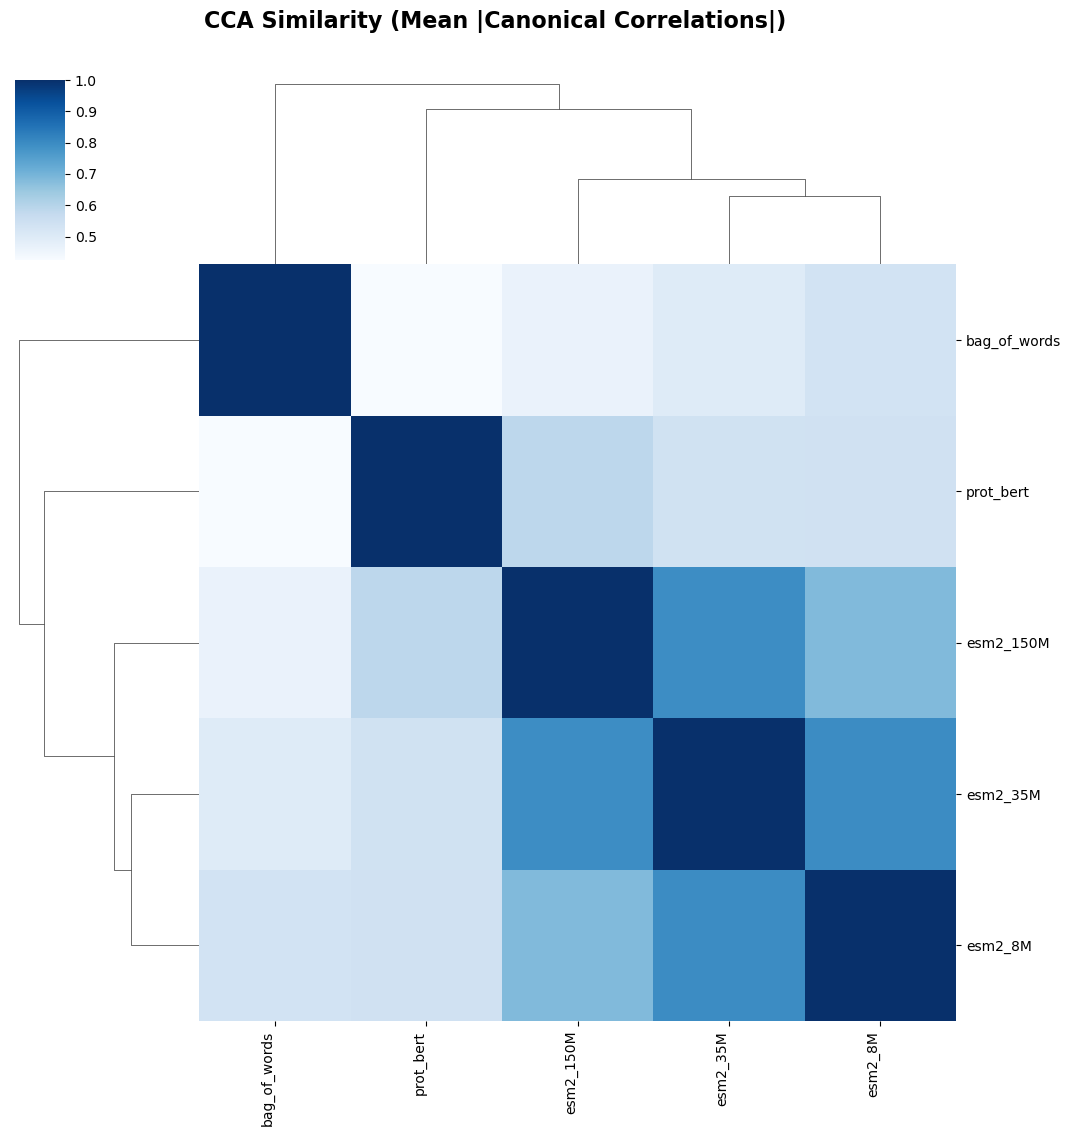

In [11]:
plt.figure(figsize=(10, 10))
g = sns.clustermap(
    sim_df,
    cmap="Blues",
    square=True,
    annot=False,
    cbar_kws={"shrink": 0.5},
)
g.fig.suptitle("CCA Similarity (Mean |Canonical Correlations|)", y=1.05, fontsize=16, fontweight="bold")
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha="right")
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()